In [1]:
# Block 1: Import Libraries and Create BinanceDataOrganizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from src.config import test_config, production_config
from src.binance_data_organizer import BinanceDataOrganizer

# Configure matplotlib to prevent pop-ups
plt.ioff()

print("🔍 SCALING VERIFICATION - CLEAN IMPLEMENTATION")
print("=" * 50)
print("✅ Imports successful")

# Create BinanceDataOrganizer with test configuration
config = production_config
organizer = BinanceDataOrganizer(config)

print(f"📈 Data Config: {config.symbol} {config.timeframe} {config.start_date} to {config.end_date}")
print(f"📊 Sequence Length: {config.sequence_length}, Prediction Length: {config.prediction_length}")
print(f"📋 Data Shape: {organizer.raw_data.shape}")
print(f"📋 Data Columns: {list(organizer.raw_data.columns)}")
print("✅ BinanceDataOrganizer created successfully")


🔍 SCALING VERIFICATION - CLEAN IMPLEMENTATION
✅ Imports successful
📈 Data Config: BTCUSDT 5m 2021-01 to 2021-06
📊 Sequence Length: 100, Prediction Length: 30
📋 Data Shape: (52009, 4)
📋 Data Columns: ['Open', 'High', 'Low', 'Close']
✅ BinanceDataOrganizer created successfully


In [2]:
# Block 2: Load Unscaled, Scaled, and Descaled Data
print("\n📊 LOADING DATA - UNSCALED, SCALED, AND DESCALED")
print("=" * 60)

# Get unscaled data
print("1️⃣ Loading unscaled data...")
unscaled_data = organizer.get_unscaled_split_data()
X_train_unscaled = unscaled_data['input_train']
y_train_unscaled = unscaled_data['output_train']

print(f"   X_train shape: {X_train_unscaled.shape}")
print(f"   y_train shape: {y_train_unscaled.shape}")
print(f"   OHLC range: {X_train_unscaled[:, :, [0,1,2,3]].min():.2f} to {X_train_unscaled[:, :, [0,1,2,3]].max():.2f}")

print("\n2️⃣ Loading scaled data")
scaled_data = organizer.get_scaled_data()
X_train_scaled = scaled_data['input_train_scaled']
y_train_scaled = scaled_data['output_train_scaled']

print(f"   X_train_scaled shape: {X_train_scaled.shape}")
print(f"   y_train_scaled shape: {y_train_scaled.shape}")

print(f"   OHLC scaled range: {X_train_scaled[:, :, [0,1,2,3]].min():.6f} to {X_train_scaled[:, :, [0,1,2,3]].max():.6f}")



📊 LOADING DATA - UNSCALED, SCALED, AND DESCALED
1️⃣ Loading unscaled data...
   X_train shape: (41504, 100, 4)
   y_train shape: (41504, 90)
   OHLC range: 28130.00 to 64854.00

2️⃣ Loading scaled data
   X_train_scaled shape: (41504, 100, 4)
   y_train_scaled shape: (41504, 90)
   OHLC scaled range: 0.000000 to 1.000000



📊 DISPLAYING CANDLESTICK CHARTS - COMBINED INPUT + OUTPUT
📈 Creating candlestick charts for combined sequence (130 timesteps)...
   Input timesteps: 100
   Output timesteps: 30
   Total timesteps: 130

1️⃣ Unscaled Data Candlestick Chart (Input + Output):


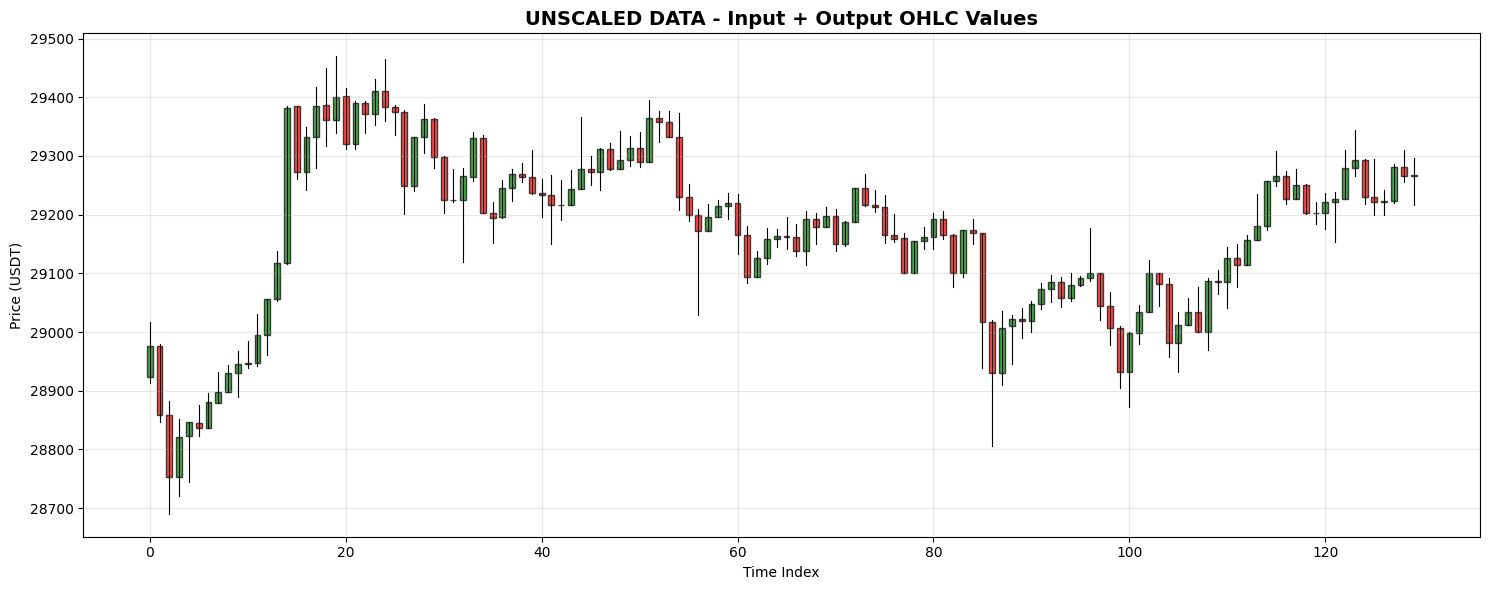


2️⃣ Scaled Data Candlestick Chart (Input + Output):


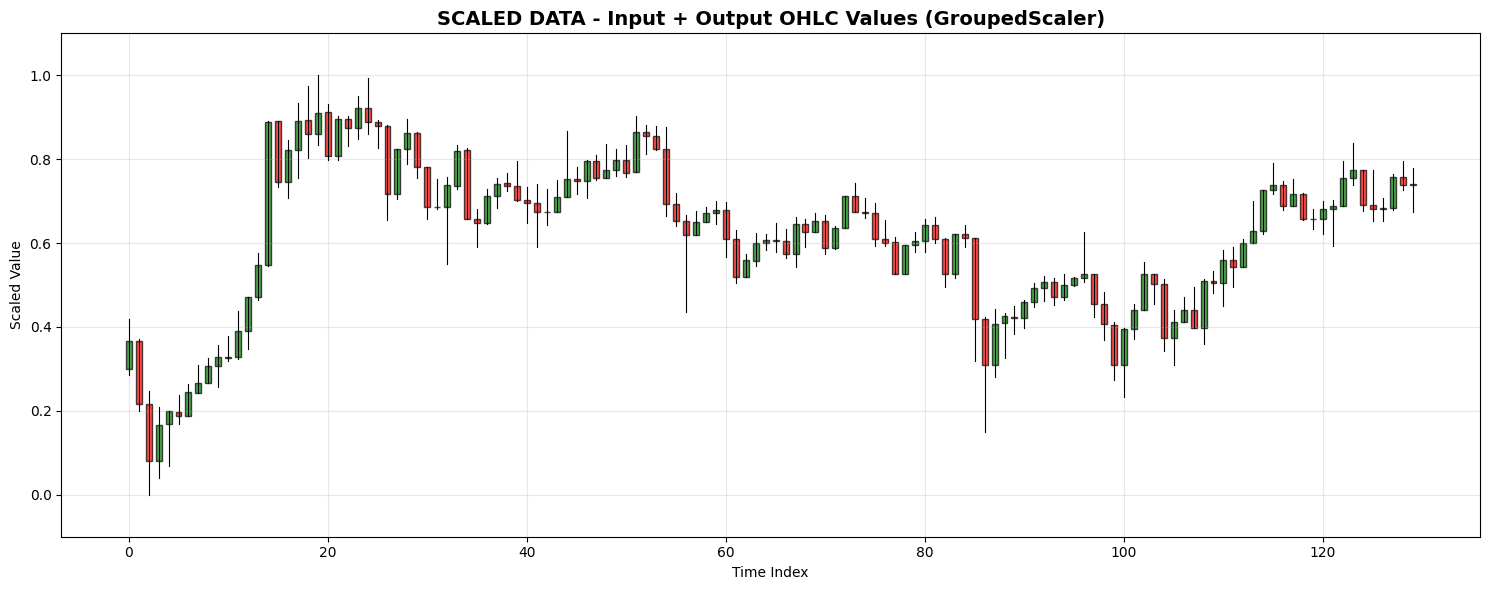


📊 CHART SUMMARY STATISTICS:
   Unscaled OHLC range: 28690.17 to 29470.00
   Scaled OHLC range: 0.000000 to 1.000000

📊 High-Low Relationship Check:
   Unscaled - All positive: True
   Scaled - All positive: True

📊 Input vs Output Analysis:
   Input timesteps (0-99):
     Unscaled range: 28690.17 to 29470.00
     Scaled range: 0.000000 to 1.000000
   Output timesteps (100-129):
     Unscaled range: 28872.24 to 29344.97
     Scaled range: 0.233474 to 0.839670

✅ All candlestick charts displayed successfully!
   Charts show combined Input + Output data for continuous visualization
   Output scaling uses same min/max as input for relationship preservation


In [3]:
# Block 3: Display Candlestick Charts for Combined Input + Output Data
print("\n📊 DISPLAYING CANDLESTICK CHARTS - COMBINED INPUT + OUTPUT")
print("=" * 60)

# Combine unscaled and scaled data using class method
first_sequence_unscaled = organizer.combine_input_output_for_chart(X_train_unscaled[0], y_train_unscaled[0])
first_sequence_scaled = organizer.combine_input_output_for_chart(X_train_scaled[0], y_train_scaled[0])

print(f"📈 Creating candlestick charts for combined sequence ({len(first_sequence_unscaled)} timesteps)...")
print(f"   Input timesteps: {config.sequence_length}")
print(f"   Output timesteps: {config.prediction_length}")
print(f"   Total timesteps: {len(first_sequence_unscaled)}")

# Helper function to draw candlestick chart
def draw_candlestick_chart(data, title, ylabel, ylim=None):
    fig, ax = plt.subplots(figsize=(15, 6))
    
    for i in range(len(data)):
        open_price = data[i, 0]
        high_price = data[i, 1]
        low_price = data[i, 2]
        close_price = data[i, 3]
        
        # Determine color based on open vs close
        color = 'green' if close_price >= open_price else 'red'
        
        # Draw the high-low line
        ax.plot([i, i], [low_price, high_price], color='black', linewidth=0.8)
        
        # Draw the open-close rectangle
        body_height = abs(close_price - open_price)
        body_bottom = min(open_price, close_price)
        
        if body_height > 0:
            rect = Rectangle((i-0.3, body_bottom), 0.6, body_height, 
                            facecolor=color, edgecolor='black', alpha=0.7)
            ax.add_patch(rect)
        else:
            # Doji - just a line
            ax.plot([i-0.3, i+0.3], [open_price, open_price], color='black', linewidth=2)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Time Index')
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    if ylim:
        ax.set_ylim(ylim)
    
    plt.tight_layout()
    plt.show()

# Chart 1: Unscaled Data (Input + Output)
print("\n1️⃣ Unscaled Data Candlestick Chart (Input + Output):")
draw_candlestick_chart(
    first_sequence_unscaled, 
    'UNSCALED DATA - Input + Output OHLC Values', 
    'Price (USDT)'
)

# Chart 2: Scaled Data (Input + Output)
print("\n2️⃣ Scaled Data Candlestick Chart (Input + Output):")
draw_candlestick_chart(
    first_sequence_scaled, 
    'SCALED DATA - Input + Output OHLC Values (GroupedScaler)', 
    'Scaled Value',
    ylim=(-0.1, 1.1)
)

# Summary Statistics
print(f"\n📊 CHART SUMMARY STATISTICS:")
print(f"   Unscaled OHLC range: {first_sequence_unscaled[:, [0,1,2,3]].min():.2f} to {first_sequence_unscaled[:, [0,1,2,3]].max():.2f}")
print(f"   Scaled OHLC range: {first_sequence_scaled[:, [0,1,2,3]].min():.6f} to {first_sequence_scaled[:, [0,1,2,3]].max():.6f}")

# Check High-Low relationships
unscaled_high_low = first_sequence_unscaled[:, 1] - first_sequence_unscaled[:, 2]
scaled_high_low = first_sequence_scaled[:, 1] - first_sequence_scaled[:, 2]

print(f"\n📊 High-Low Relationship Check:")
print(f"   Unscaled - All positive: {np.all(unscaled_high_low >= 0)}")
print(f"   Scaled - All positive: {np.all(scaled_high_low >= 0)}")

# Show input vs output ranges
input_end = config.sequence_length
print(f"\n📊 Input vs Output Analysis:")
print(f"   Input timesteps (0-{input_end-1}):")
print(f"     Unscaled range: {first_sequence_unscaled[:input_end, [0,1,2,3]].min():.2f} to {first_sequence_unscaled[:input_end, [0,1,2,3]].max():.2f}")
print(f"     Scaled range: {first_sequence_scaled[:input_end, [0,1,2,3]].min():.6f} to {first_sequence_scaled[:input_end, [0,1,2,3]].max():.6f}")
print(f"   Output timesteps ({input_end}-{len(first_sequence_unscaled)-1}):")
print(f"     Unscaled range: {first_sequence_unscaled[input_end:, [0,1,2,3]].min():.2f} to {first_sequence_unscaled[input_end:, [0,1,2,3]].max():.2f}")
print(f"     Scaled range: {first_sequence_scaled[input_end:, [0,1,2,3]].min():.6f} to {first_sequence_scaled[input_end:, [0,1,2,3]].max():.6f}")

print(f"\n✅ All candlestick charts displayed successfully!")
print(f"   Charts show combined Input + Output data for continuous visualization")
print(f"   Output scaling uses same min/max as input for relationship preservation")


In [4]:
# Print sample data for comparison
print("\n📊 SAMPLE DATA COMPARISON - COMBINED INPUT + OUTPUT")
print("=" * 70)

# Print first 10 rows of unscaled data
print("🔍 UNSCALED DATA (first 10 rows - Input + Output):")
print("Index    Open      High      Low       Close")
print("-" * 45)
for i in range(10):
    row = first_sequence_unscaled[i]
    print(f"{i:5d}  {row[0]:8.2f}  {row[1]:8.2f}  {row[2]:8.2f}  {row[3]:8.2f}")

print("\n🔍 SCALED DATA (first 10 rows - Input + Output):")
print("Index    Open      High      Low       Close")
print("-" * 45)
for i in range(10):
    row = first_sequence_scaled[i]
    print(f"{i:5d}  {row[0]:8.6f}  {row[1]:8.6f}  {row[2]:8.6f}  {row[3]:8.6f}")

# Show transition from input to output
input_end = config.sequence_length
print(f"\n🔄 INPUT TO OUTPUT TRANSITION:")
print(f"   Input ends at timestep {input_end-1}, Output starts at timestep {input_end}")
print(f"   Last input Close: {first_sequence_unscaled[input_end-1, 3]:.2f}")
print(f"   First output Open: {first_sequence_unscaled[input_end, 0]:.2f} (should match)")

print("\n📈 DATA RANGES:")
print(f"   Unscaled OHLC: {first_sequence_unscaled[:, [0,1,2,3]].min():.2f} to {first_sequence_unscaled[:, [0,1,2,3]].max():.2f}")
print(f"   Scaled OHLC:   {first_sequence_scaled[:, [0,1,2,3]].min():.6f} to {first_sequence_scaled[:, [0,1,2,3]].max():.6f}")

print(f"\n✅ Combined data shows continuous Input + Output visualization")
print(f"   Output scaling preserves relationship with input data")



📊 SAMPLE DATA COMPARISON - COMBINED INPUT + OUTPUT
🔍 UNSCALED DATA (first 10 rows - Input + Output):
Index    Open      High      Low       Close
---------------------------------------------
    0  28923.63  29017.50  28913.12  28975.65
    1  28975.65  28979.53  28846.28  28858.94
    2  28858.94  28883.20  28690.17  28752.80
    3  28752.80  28852.48  28720.91  28820.72
    4  28822.17  28846.46  28744.09  28846.46
    5  28844.88  28875.55  28822.00  28836.63
    6  28836.63  28896.54  28836.62  28880.38
    7  28879.48  28932.13  28879.48  28897.97
    8  28897.97  28943.87  28897.96  28930.11
    9  28930.11  28968.40  28889.99  28946.32

🔍 SCALED DATA (first 10 rows - Input + Output):
Index    Open      High      Low       Close
---------------------------------------------
    0  0.299373  0.419745  0.285896  0.366080
    1  0.366080  0.371055  0.200185  0.216419
    2  0.216419  0.247528  0.000000  0.080312
    3  0.080312  0.208135  0.039419  0.167408
    4  0.169268  0.2004